# Superheroes battle
Questa lezione costituisce un esempio complessivo dell'uso di oggetti, lettura di file, e strutture dati.

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import random
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from IPython.display import clear_output
import time

## La gara
Nel nostro gioco i supereroi *Marvel* sfidano i supereroi *DC* su una mappa quadrata. 
- Il gioco è diviso in turni. 
- In ogni turno un supereroe si muove sulla mappa
- Se un supereroe X muovendosi sulla mappa si imbatte in un altro supereroe Y avviene una di queste due cose:
    - Se X appartiene alla stessa squadra di Y: X è eliminato dal gioco e i suoi valori di attacco e difesa sono aggiunti a quelli di Y
    - Se X e Y sono di squadre diverse avviene un combattimento che dura fino all'eliminazione di uno dei due
- Se invece il campo di arrivo sulla mappa è vuoto: X occupa il campo e acquisisce una delle risorse lì conservate

# Classi

## Hero
Rappresenta un supereroe, caratterizzato dalla squadra a cui appartiene e da una resistenza iniziale, una forza in attacco e una in difesa che dipendono dall'altezza, dal peso, dal sesso, e dalla squadra di appartenenza. I supereroi Marvel si muovono di una sola posizione in qualsiasi direzione, quelli DC di una o due posizioni ma solo in direzione verticale o orizzontale. Il movimento avviene sempre nella direzione dei campi con maggiori risorse.

In [3]:
class Hero(object):
    
    x_map = {'M': 2, 'F': 1}

    def __init__(self, name, height, weight, strength, sex):
        self.name = name
        self.h = height
        self.w = weight
        self.s = strength
        self.x = sex
        self.stamina = Hero.x_map[self.x] * (self.w / 10 + self.h / 10)
        self.attack = self.s * Hero.x_map[self.x]
        self.defense = (self.h + self.w) * Hero.x_map[self.x]
        self.color = '#009900'
        self.x, self.y = None, None
    
    def fight(self, enemy):
        while self.stamina > 0 and enemy.stamina > 0:
            if np.random.uniform() < float(self.attack) / enemy.defense:
                enemy.stamina -= 2
            if np.random.uniform() < float(enemy.attack) / self.defense:
                self.stamina -= 2
        if enemy.stamina >= self.stamina:
            return enemy
        else:
            return self
    
    def eat(self, field):
        self.stamina += field.get_resource()
        
    def move(self, battlefield):
        pass
    
    def __unicode__(self):
        u = u'name: {}\n attack: {}\n defense: {}\n stamina: {}'.format(
            self.name, self.attack, self.defense, self.stamina
        )
        return u
    
    def print_h(self):
        print unicode(self)
            
        
class Marvel(Hero):
    
    def __init__(self, name, height, weight, strength, sex):
        super(Marvel, self).__init__(name, height, weight, strength, sex)
        self.color = '#990000'
    
    def move(self, battlefield):
        options = []
        self.stamina -= 1
        field = battlefield.grid[self.x][self.y]
        field.owner = None
        for a in range(self.x-1, self.x+2):
            for b in range(self.y-1, self.y+2):
                if battlefield.grid[a][b] is not None and a != self.x and b != self.y:
                    options.append(battlefield.grid[a][b])
        options = sorted(options, key=lambda x: -x.resources)
        options[0].occupy(self)

        
class DC(Hero):
    
    def __init__(self, name, height, weight, strength, sex):
        super(DC, self).__init__(name, height, weight, strength, sex)
        self.color = '#000099'
        
    def move(self, battlefield):
        options = []
        self.stamina -= 1
        field = battlefield.grid[self.x][self.y]
        field.owner = None
        for a in range(self.x-2, self.x+3):
            if battlefield.grid[a][self.y] is not None and a != self.x:
                options.append(battlefield.grid[a][self.y])
        for b in range(self.y-2, self.y+3):
            if battlefield.grid[self.x][b] is not None and b != self.y:
                options.append(battlefield.grid[self.x][b])
        options = sorted(options, key=lambda x: -x.resources)
        options[0].occupy(self)

### Field
Rappresenta un campo della mappa di gioco. Il campo è dotato di un numero di risorse che vengono consumate progressivamente all'arrivo dell'occupante.

In [4]:
class Field(object):
    
    def __init__(self, x, y, max_resources=10):
        self.x, self.y = x, y
        self.max_resources = max_resources
        self.resources = random.randint(0, self.max_resources)
        self.owner = None
    
    def get_resource(self):
        self.resources -= 1
        if self.resources > 0:
            return 2
        else:
            self.resources = 0
            return 0
    
    def occupy(self, hero):
        if self.owner is None:
            h = hero
        else:
            if type(hero) is type(self.owner):
                self.owner.attack += hero.attack
                self.owner.defense += hero.defense
                hero.stamina = -1
                h = self.owner
            else:
                winner = hero.fight(self.owner)
                h = winner
        self.owner = h
        self.owner.eat(self)
        self.owner.x, self.owner.y = self.x, self.y

### BattleField
Rappresenta la mappa di gioco come una griglia occupata da Field. Fornisce anche un metodo per la visualizzazione del campo.

In [5]:
class BattleField(object):
    
    def __init__(self, size=200, resources_per_field=10):
        self.size, self.res = size, resources_per_field
        self.fields = [Field(x, y, max_resources=resources_per_field) for y in range(self.size) 
                       for x in range(self.size)]
        self.grid = defaultdict(lambda: defaultdict(lambda: None))
        for f in self.fields:
            self.grid[f.x][f.y] = f
        self.heroes = set()
        
    def add_hero(self, hero):
        i = np.random.randint(0,len(self.fields))
        f = self.fields[i]
        f.occupy(hero)
        self.heroes.add(f.owner)
        
    def clock(self):
        h = set()
        for hero in self.heroes:
            if hero.stamina > 0:
                hero.move(self)
                h.add(hero)
            else:
                field = self.grid[hero.x][hero.y]
                field.owner = None
        self.heroes = h
        
    def show(self, figsize=(6, 6)):
        grid = np.zeros((self.size, self.size))
        x, y, colors = [], [], []
        for f in self.fields:
            grid[f.x][f.y] = float(f.resources) / self.res
            if f.owner is not None:
                x.append(f.x)
                y.append(f.y)
                colors.append(f.owner.color)
        fig, ax = plt.subplots(figsize=figsize)
        ax.scatter([f.x for f in self.fields], [f.y for f in self.fields],
                   c=[f.resources for f in self.fields], cmap='binary', alpha=0.2,
                  marker='s', s=200)
        ax.scatter(x, y, c=colors)  
        plt.show()

## Playground

In [6]:
F = BattleField(size=10, resources_per_field=4)

In [ ]:
d = DC('A', 173, 76, 200, 'F')
m = Marvel('B', 173, 76, 100, 'F')
k = Marvel('C', 173, 76, 100, 'M')

In [ ]:
F.add_hero(d)
F.add_hero(m)
F.add_hero(k)

In [ ]:
F.show(figsize=(3, 3))

In [ ]:
#print [(h.name, h.stamina, h.x, h.y) for h in F.heroes]
#print [(f.x, f.y, f.resources) for f in F.fields]

for i in range(0,20):
    F.show((6,6))
    F.clock()
    # print [(h.name, h.stamina, h.x, h.y) for h in F.heroes]
    # print [(f.x, f.y, f.resources) for f in F.fields]
    if len(F.heroes) == 1:
        print 'WINNER'
        list(F.heroes)[0].print_h()
        F.show()
        break
    clear_output(wait=True)
    time.sleep(1.5)

# PLAY

In [7]:
def load_file(path):
    heroes = []
    with open(path, 'rU') as infile:
        lines = infile.readlines()
    for line in lines[1:]:
        l = line.rstrip('\n').split(';')
        try:
            name, height, weight  = l[0], float(l[4]), float(l[5])
            strength, sex, pub = int(l[10]), l[6], l[3]
            if pub == 'Marvel Comics':
                h = Marvel(name, height, weight, strength, sex)
            elif pub == 'DC Comics':
                h = DC(name, height, weight, strength, sex)
            else:
                pass
            heroes.append(h)
        except IndexError:
            pass
        except ValueError:
            pass
        except KeyError:
            pass
    return heroes

In [8]:
heroes = load_file('data/heroes.csv')

In [9]:
F = BattleField(size=20, resources_per_field=4)
for hero in heroes:
    F.add_hero(hero)

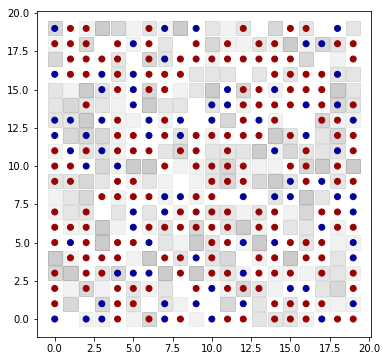

In [10]:
F.show()

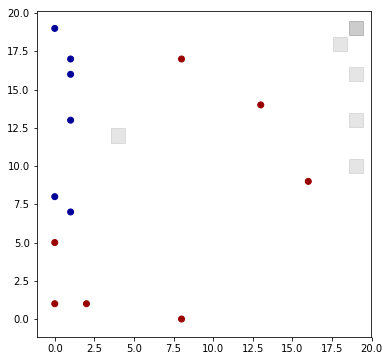

9


In [11]:
for i in range(0,20):
    F.show()
    F.clock()
    if len(F.heroes) == 1:
        print 'WINNER'
        list(F.heroes)[0].print_h()
        F.show()
        break
    print len(F.heroes)
    clear_output(wait=True)
    time.sleep(1)